<a href="https://colab.research.google.com/github/ruhi-doshi/dbc/blob/ml/internalhack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

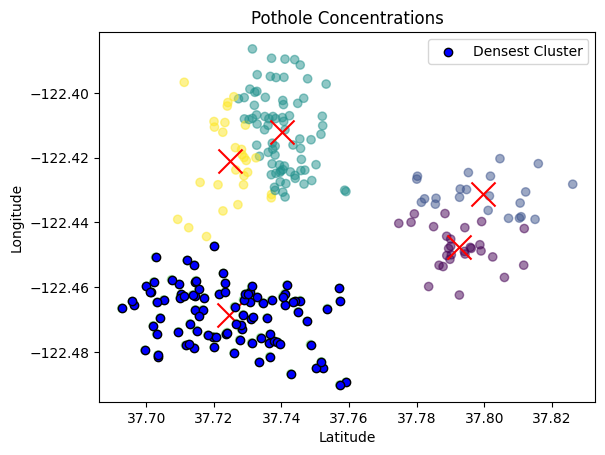

In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
#from sklearn.impute import SimpleImputer
#from sklearn.decomposition import PCA

# Function to generate synthetic data
def generate_pothole_data(num_clusters, points_per_cluster, cluster_spread):
    np.random.seed(42)  # For reproducibility
    data = []

    # Generate clusters
    for _ in range(num_clusters):
        # Randomly choose a cluster center
        cluster_center = np.random.uniform(low=[37.7, -122.5], high=[37.8, -122.4])
        # Generate points around the cluster center
        cluster_points = cluster_center + cluster_spread * np.random.randn(points_per_cluster, 2)
        data.append(cluster_points)

    return np.vstack(data)

# Generate synthetic pothole data
num_clusters = 5
points_per_cluster = 50
cluster_spread = 0.01
data = generate_pothole_data(num_clusters, points_per_cluster, cluster_spread)

# Convert data to TensorFlow tensor
data = tf.constant(data, dtype=tf.float32)

# Parameters
k = 5
max_iters = 100
tolerance = 1e-4
#tolersnce is threshold for the convergence of the K-means algorithm.

# Initialize centroids by selecting k random points from the data
centroids = tf.Variable(tf.gather(data, tf.random.shuffle(tf.range(tf.shape(data)[0]))[:k]))

# Function to assign points to the nearest centroid
def assign_clusters(data, centroids):
    expanded_data = tf.expand_dims(data, 0)
    expanded_centroids = tf.expand_dims(centroids, 1)
    distances = tf.reduce_sum(tf.square(expanded_data - expanded_centroids), 2)
    return tf.argmin(distances, 0)

# Function to update centroids
def update_centroids(data, assignments, k):
    new_centroids = []
    for c in range(k):
        points_for_centroid = tf.boolean_mask(data, tf.equal(assignments, c))
        new_centroids.append(tf.reduce_mean(points_for_centroid, axis=0))
    return tf.stack(new_centroids)

# K-means algorithm
for i in range(max_iters):
    # Assign points to nearest centroid
    assignments = assign_clusters(data, centroids)

    # Update centroids
    new_centroids = update_centroids(data, assignments, k)

    # Check for convergence
    centroid_shift = tf.reduce_sum(tf.square(new_centroids - centroids))
    centroids.assign(new_centroids)

    if centroid_shift < tolerance:
        break
import pandas as pd
df = pd.DataFrame(data, columns=['latitude', 'longitude'])

# Display first few rows of the generated data
#print(df.head())

# 1. Normalize/Standardize Data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Convert assignments to numpy for visualization
assignments = assignments.numpy()

# Get the final centroids
final_centroids = centroids.numpy()

# Identify the densest cluster
unique, counts = np.unique(assignments, return_counts=True)
densest_cluster = unique[np.argmax(counts)]

# Plotting the clusters
plt.scatter(data[:, 0], data[:, 1], c=assignments, cmap='viridis', alpha=0.5)
plt.scatter(final_centroids[:, 0], final_centroids[:, 1], s=300, c='red', marker='x')  # Centroids

#the densest cluster
dense_cluster_points = data[assignments == densest_cluster]
plt.scatter(dense_cluster_points[:, 0], dense_cluster_points[:, 1], c='blue', edgecolor='k', label='Densest Cluster')

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Pothole Concentrations')
plt.legend()
plt.show()


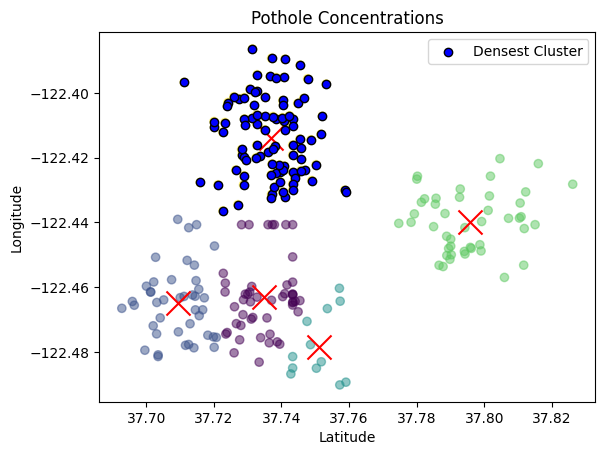

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd
from scipy import stats
def generate_pothole_data(num_clusters, points_per_cluster, cluster_spread):
    np.random.seed(42)
    data = []
    for _ in range(num_clusters):
        cluster_center = np.random.uniform(low=[37.7, -122.5], high=[37.8, -122.4])
        cluster_points = cluster_center + cluster_spread * np.random.randn(points_per_cluster, 2)
        data.append(cluster_points)

    return np.vstack(data)

#synthetic pothole data
num_clusters = 5
points_per_cluster = 50
cluster_spread = 0.01
data = generate_pothole_data(num_clusters, points_per_cluster, cluster_spread)
data_with_nans = data.copy()
data_with_nans[::10, 0] = np.nan
data_with_nans[::15, 1] = np.nan
df = pd.DataFrame(data_with_nans, columns=['latitude', 'longitude'])
imputer = SimpleImputer(strategy='mean')  # Impute missing values with the mean
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df = df.drop_duplicates()
#Z-score: The Z-score measures how many standard deviations a data point is from the mean of the data.
z_scores = np.abs(stats.zscore(df))
df = df[(z_scores < 3).all(axis=1)]
data = tf.constant(df, dtype=tf.float32)

# Default Parameters
k = 5
max_iters = 100
tolerance = 1e-4
centroids = tf.Variable(tf.gather(data, tf.random.shuffle(tf.range(tf.shape(data)[0]))[:k]))

# Function to assign points to the nearest centroid
def assign_clusters(data, centroids):
    expanded_data = tf.expand_dims(data, 0)
    expanded_centroids = tf.expand_dims(centroids, 1)
    distances = tf.reduce_sum(tf.square(expanded_data - expanded_centroids), 2)
    return tf.argmin(distances, 0)
def update_centroids(data, assignments, k):
    new_centroids = []
    for c in range(k):
        points_for_centroid = tf.boolean_mask(data, tf.equal(assignments, c))
        new_centroids.append(tf.reduce_mean(points_for_centroid, axis=0))
    return tf.stack(new_centroids)

# K-means algorithm
for i in range(max_iters):
    assignments = assign_clusters(data, centroids)
    new_centroids = update_centroids(data, assignments, k)
    centroid_shift = tf.reduce_sum(tf.square(new_centroids - centroids))
    centroids.assign(new_centroids)

    if centroid_shift < tolerance:
        break

#visualization
assignments = assignments.numpy()
final_centroids = centroids.numpy()
unique, counts = np.unique(assignments, return_counts=True)
densest_cluster = unique[np.argmax(counts)]
plt.scatter(df['latitude'], df['longitude'], c=assignments, cmap='viridis', alpha=0.5)
plt.scatter(final_centroids[:, 0], final_centroids[:, 1], s=300, c='red', marker='x')  # Centroids
dense_cluster_points = df.iloc[assignments == densest_cluster]
plt.scatter(dense_cluster_points['latitude'], dense_cluster_points['longitude'], c='blue', edgecolor='k', label='Densest Cluster')

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Pothole Concentrations')
plt.legend()
plt.show()
